<h1>6. Machine Learning für Zeitreihen: Überblick & Klassifikation</h1>
<h4>Session 6 (Mittwoch 11:00 – 12:30)</h4>
<br>
6.1 Besonderheiten Machine Learning für Zeitreihen<br>
6.2 Datenvorbereitung: Merkmalsbestimmung (Feature extraction), ...<br>
6.3 Klassifikation in Zeitreihendaten<br>

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import tree

<h2>7.1 Random Forest Klassifikation mit Zeitreihen: Belegungserkennung aus Temperatur-, Feuchte-, Licht- und CO2-Messungen</h2>

<h3> Datensatz einlesen </h3>

In [35]:
occ = pd.read_csv("occupancy.txt")
occ['date'] = pd.to_datetime(occ['date'])
occ.set_index('date', inplace=True)
occ.columns = ['Temperatur','Feuchte','Licht','CO2','Feuchte-Ratio','Belegt']
occ.head()
#occ.info()
#occ.describe()

Temperatur  Feuchte  Licht     CO2  Feuchte-Ratio  Belegt
date                                                                          
2015-02-04 17:51:00       23.18  27.2720  426.0  721.25       0.004793       1
2015-02-04 17:51:59       23.15  27.2675  429.5  714.00       0.004783       1
2015-02-04 17:53:00       23.15  27.2450  426.0  713.50       0.004779       1
2015-02-04 17:54:00       23.15  27.2000  426.0  708.25       0.004772       1
2015-02-04 17:55:00       23.10  27.2000  426.0  704.50       0.004757       1

Text(0, 0.5, 'Belegt?')

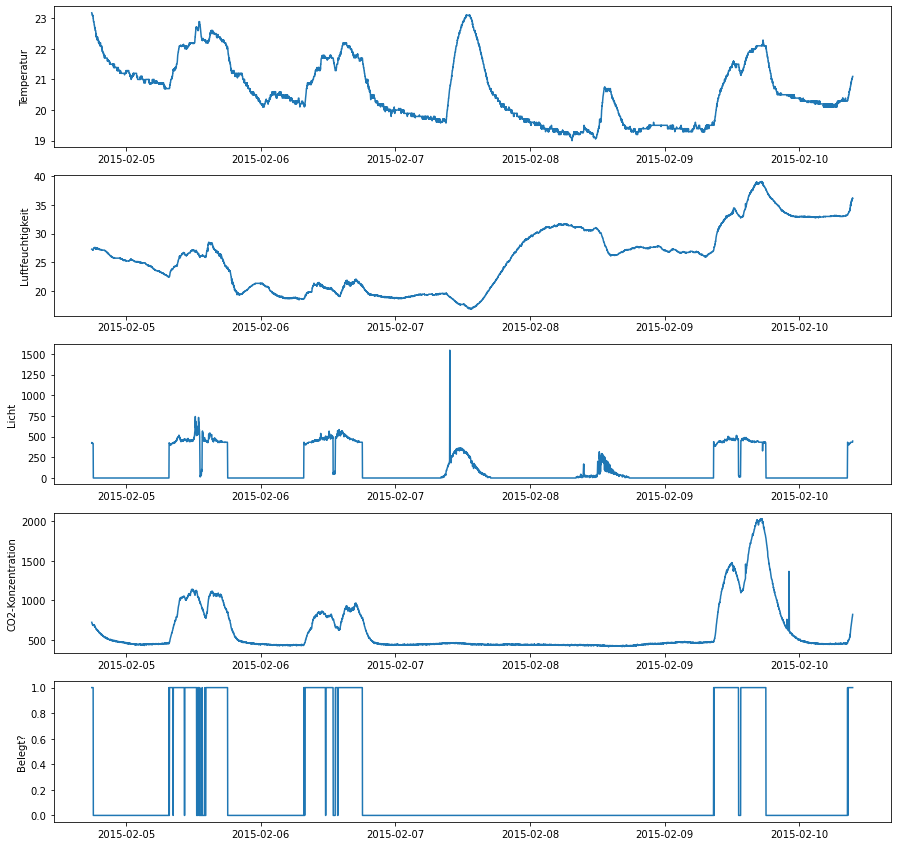

In [36]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))
ax1.plot(occ['Temperatur'])
ax1.set_ylabel("Temperatur")
ax2.plot(occ['Feuchte'])
ax2.set_ylabel("Luftfeuchtigkeit")
ax3.plot(occ['Licht'])
ax3.set_ylabel("Licht")
ax4.plot(occ['CO2'])
ax4.set_ylabel("CO2-Konzentration")
ax5.plot(occ['Belegt'])
ax5.set_ylabel("Belegt?")

### Vorverarbeitung, Datenbereinigung, Umgang mit Zeitvariablen

In [37]:
fig = px.line(occ, x=occ.index, y=occ['Licht'])
fig.show()

In [38]:
occ.loc[(occ.index.normalize() == pd.to_datetime('2015-02-07')) & (occ['Licht'] > 400), 'Licht'] = np.nan

In [39]:
#occ['Licht'].fillna(method='ffill', inplace=True)
occ['Licht'].interpolate(method='linear', inplace=True)

In [40]:
fig = px.line(occ, x=occ.index, y=occ['Licht'])
fig.show()

In [43]:
fig = px.line(occ, x=occ.index, y=occ['CO2'])
fig.show()

In [44]:
occ.loc[(occ.index >= '2015-02-09 22:00') & (occ.index <= '2015-02-09 22:30') & (occ['CO2'] > 800), 'CO2'] = np.nan

In [45]:
occ['CO2'].interpolate(method='linear', inplace=True)

In [46]:
fig = px.line(occ, x=occ.index, y=occ['CO2'])
fig.show()

### Umgang mit Zeitvariablen

In [47]:
occ["hour"] = occ.index.hour
occ["weekday"] = occ.index.weekday

occ.head()

Temperatur  Feuchte  Licht     CO2  Feuchte-Ratio  \
date                                                                     
2015-02-04 17:51:00       23.18  27.2720  426.0  721.25       0.004793   
2015-02-04 17:51:59       23.15  27.2675  429.5  714.00       0.004783   
2015-02-04 17:53:00       23.15  27.2450  426.0  713.50       0.004779   
2015-02-04 17:54:00       23.15  27.2000  426.0  708.25       0.004772   
2015-02-04 17:55:00       23.10  27.2000  426.0  704.50       0.004757   

                     Belegt  hour  weekday  
date                                        
2015-02-04 17:51:00       1    17        2  
2015-02-04 17:51:59       1    17        2  
2015-02-04 17:53:00       1    17        2  
2015-02-04 17:54:00       1    17        2  
2015-02-04 17:55:00       1    17        2

In [48]:
occ.loc[(occ['hour'] < 20) & (occ['hour'] > 7) & (occ['weekday'] < 5), 'workinghours'] = 'True'
occ["Arbeitszeit"] = pd.get_dummies(occ['workinghours'])

occ.head()

Temperatur  Feuchte  Licht     CO2  Feuchte-Ratio  \
date                                                                     
2015-02-04 17:51:00       23.18  27.2720  426.0  721.25       0.004793   
2015-02-04 17:51:59       23.15  27.2675  429.5  714.00       0.004783   
2015-02-04 17:53:00       23.15  27.2450  426.0  713.50       0.004779   
2015-02-04 17:54:00       23.15  27.2000  426.0  708.25       0.004772   
2015-02-04 17:55:00       23.10  27.2000  426.0  704.50       0.004757   

                     Belegt  hour  weekday workinghours  Arbeitszeit  
date                                                                  
2015-02-04 17:51:00       1    17        2         True            1  
2015-02-04 17:51:59       1    17        2         True            1  
2015-02-04 17:53:00       1    17        2         True            1  
2015-02-04 17:54:00       1    17        2         True            1  
2015-02-04 17:55:00       1    17        2         True            1

In [49]:
occ = occ.drop(['Feuchte-Ratio','hour','weekday','workinghours'], axis = 1)
occ = occ.reindex(columns=['Temperatur','Feuchte','Licht','CO2','Arbeitszeit','Belegt'])

occ.head()
#occ.info()
#occ.describe()

Temperatur  Feuchte  Licht     CO2  Arbeitszeit  Belegt
date                                                                        
2015-02-04 17:51:00       23.18  27.2720  426.0  721.25            1       1
2015-02-04 17:51:59       23.15  27.2675  429.5  714.00            1       1
2015-02-04 17:53:00       23.15  27.2450  426.0  713.50            1       1
2015-02-04 17:54:00       23.15  27.2000  426.0  708.25            1       1
2015-02-04 17:55:00       23.10  27.2000  426.0  704.50            1       1

<h3> Trainings- und Testdaten (70%:30%, zufällig) </h3>

In [50]:
labels = np.array(occ['Belegt'])
features = occ.drop(['Belegt'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state = 42)
X_test.shape

(2443, 5)

<h3> Model mit Trainingsdaten trainieren - wie wichtig sind einzelne Merkmale? </h3>

In [51]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [52]:
feature_imp = pd.DataFrame(clf.feature_importances_,index=feature_list)
feature_imp

0
Temperatur   0.049141
Feuchte      0.026030
Licht        0.507292
CO2          0.212510
Arbeitszeit  0.205028

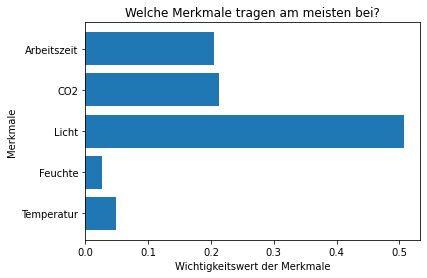

In [53]:
plt.barh(feature_imp.index,feature_imp[0])
plt.xlabel('Wichtigkeitswert der Merkmale')
plt.ylabel('Merkmale')
plt.title("Welche Merkmale tragen am meisten bei?")
plt.show()

<h3> Testdaten klassifizieren - wie gut ist unser Klassifikator? </h3>

In [54]:
y_pred=clf.predict(X_test)
print("Unser Random-Forest-Klassifizierer klassifiziert korrekt:",metrics.accuracy_score(y_test, y_pred).round(4))

Unser Random-Forest-Klassifizierer klassifiziert korrekt: 0.9959


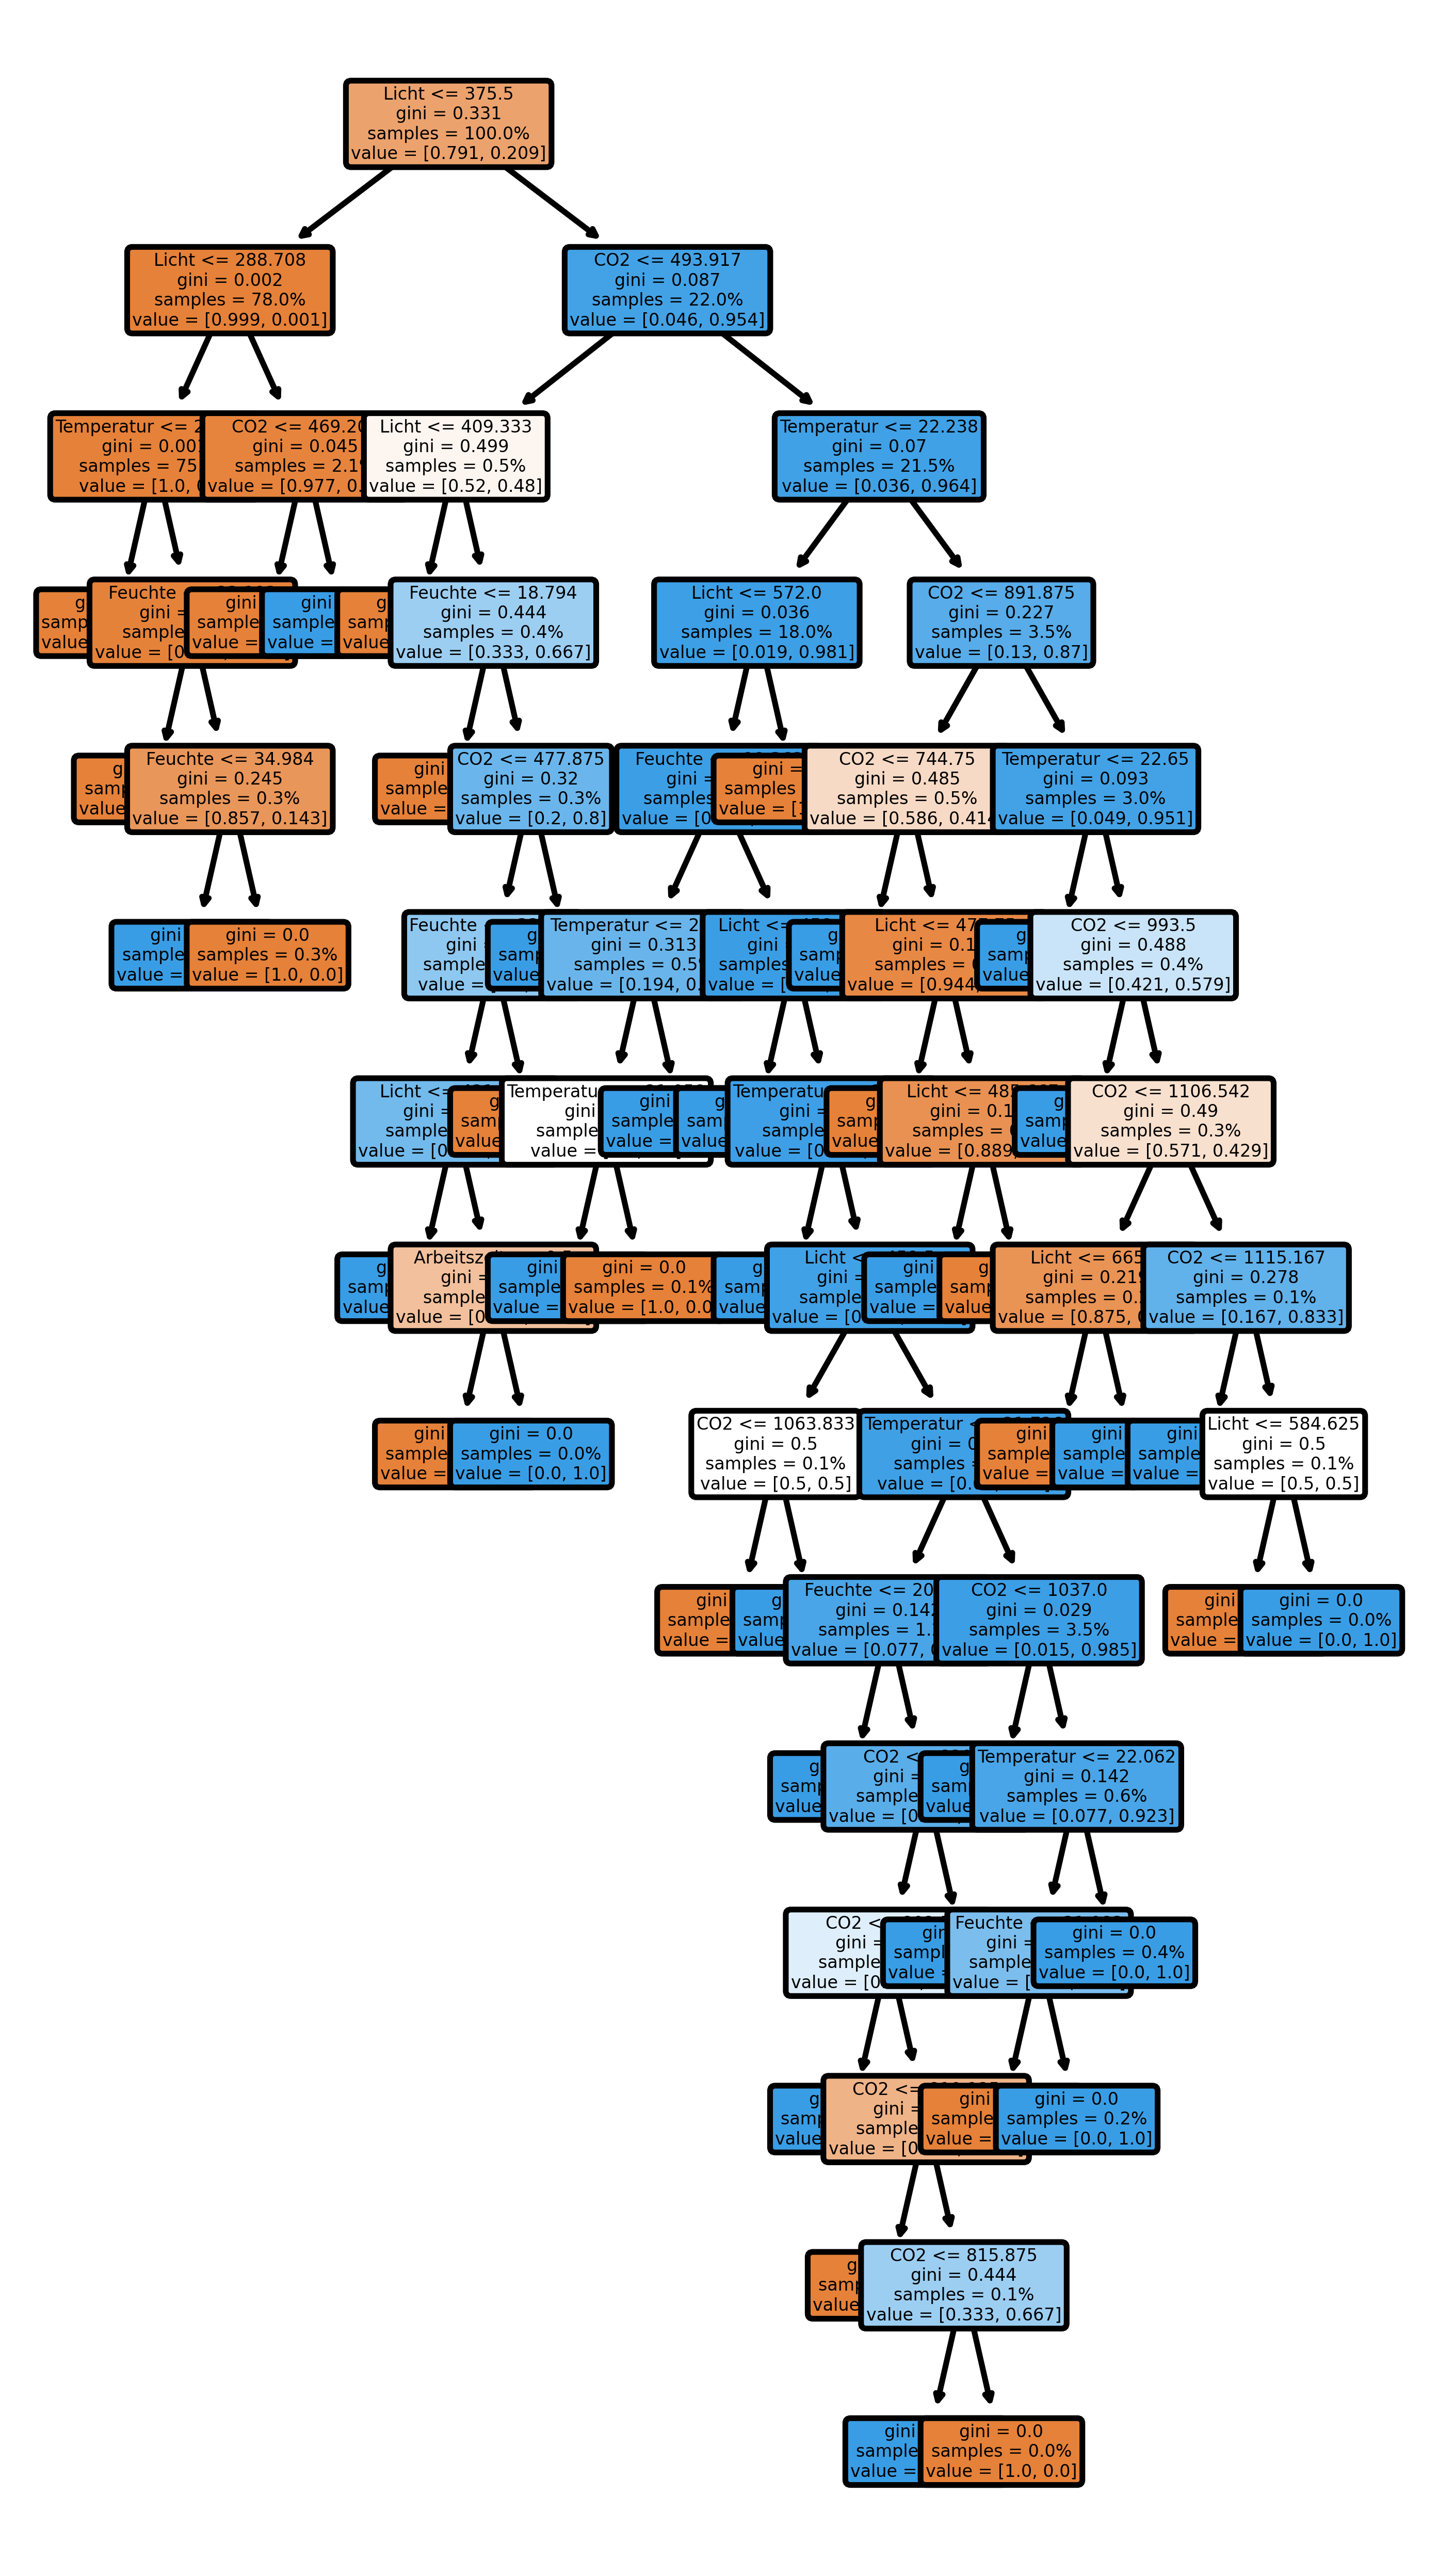

In [55]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,8), dpi=800)
tree.plot_tree(clf.estimators_[2], feature_names = feature_list, filled = True, proportion = True, rounded = True, fontsize=3);
fig.savefig('rf_einbaum.png')

<div class="alert alert-info">
- Versuche mit einem anderen Datensatz, eine ähnliche Klassifikation durchzuführen - diesmal geht es um Prediktive Wartung<br>
- Plotte dazu die Daten und entscheide, welche Features du in die Klassifikation aufnehmen willst - und was deine Labels sein sollen<br>
- Teile deine Daten in Trainings- und Testdaten<br>
- Trainiere einen Random Forest Klassifikator und klassifiziere deine Testdaten<br>
- Welche Features sind am wichtigsten? Wie viel Prozent werden korrekt klassifiziert?
</div>

In [64]:
new = pd.read_csv('ai4i2020.csv')
new.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [65]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

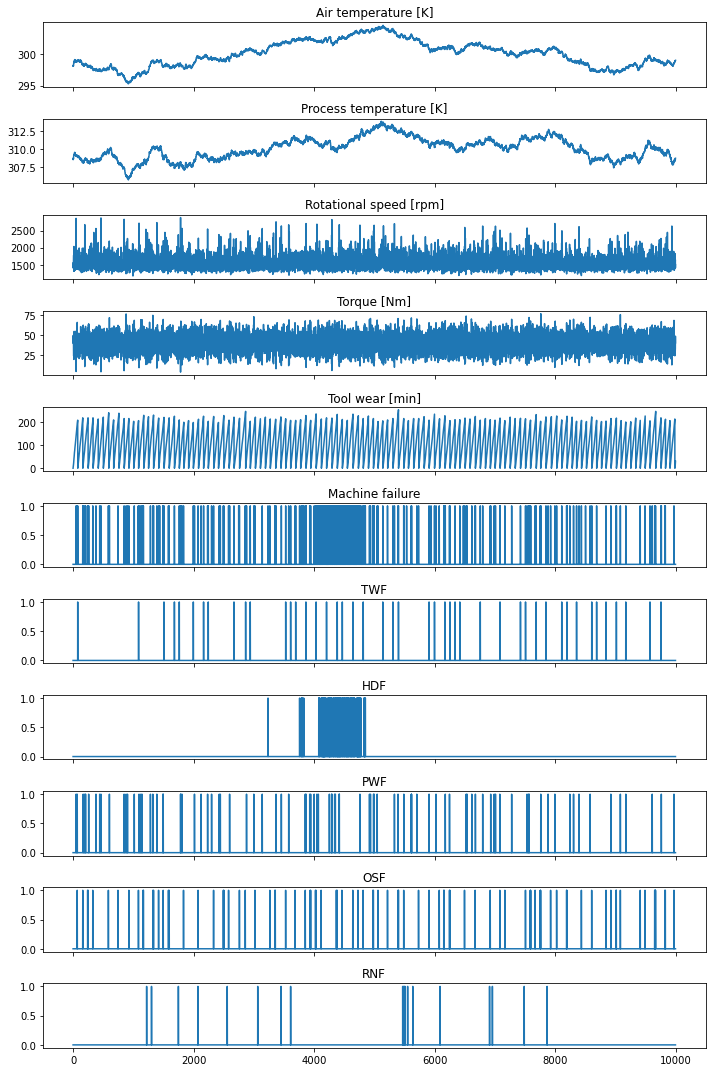

In [70]:
numerical_features = new.select_dtypes(include=['float64', 'int64']).columns.drop(['UDI'])

fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(10, 15), sharex=True)

for i, col in enumerate(numerical_features):
    axes[i].plot(new.index, new[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [69]:
fig = px.line(new, x=new.index, y=new['Air temperature [K]'])
fig.show()